In [ ]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
from matplotlib.colors import hsv_to_rgb
import random

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Sat Nov 30 19:54:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0              28W /  70W |    107MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
def generate_random_distinct_colors(n):
    """Generate n distinct colors with high contrast between adjacent colors."""
    # Create a list of evenly spaced hues
    hues = list(np.linspace(0, 1, n * 2))  # Double the number of hues for more options

    # Randomly select and shuffle hues to ensure adjacent colors are different
    selected_hues = random.sample(hues, n)

    colors = []
    for hue in selected_hues:
        # Use high saturation and value for visibility
        saturation = random.uniform(0.7, 1.0)
        value = random.uniform(0.8, 1.0)
        color = plt.cm.hsv(hue)  # Convert HSV to RGB
        # Convert to BGR and scale to 255
        color_bgr = (int(color[2] * 255), int(color[1] * 255), int(color[0] * 255))
        colors.append(color_bgr)

    # Shuffle the colors again to ensure maximum contrast between adjacent indices
    random.shuffle(colors)
    return colors


def visualize_annotations(json_path, image_folder, image_id):
    """
    Visualize dental X-ray annotations for a specific image ID.

    Args:
        json_path (str): Path to the JSON file containing annotations
        image_folder (str): Path to the folder containing images
        image_id (int): ID of the image to visualize

    Returns:
        numpy.ndarray: Image with annotations drawn
    """
    # Load JSON data
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Find image info
    image_info = next((img for img in data['images'] if img['id'] == image_id), None)
    if not image_info:
        raise ValueError(f"Image ID {image_id} not found")

    # Get annotations for this image
    annotations = [ann for ann in data['annotations'] if ann['image_id'] == image_id]

    colors = generate_random_distinct_colors(len(annotations))

    # Read the image
    image_path = f"{image_folder}/{image_info['file_name']}"
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")

    # Convert BGR to RGB for matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a copy for drawing
    vis_image = image.copy()

    # Draw annotations
    for i, ann in enumerate(annotations):
        # Get bounding box coordinates
        x, y, w, h = [int(coord) for coord in ann['bbox']]

        # Calculate proper tooth number (adding 1 to each category and concatenating)
        quadrant = ann['category_id_1'] + 1
        tooth_num = ann['category_id_2'] + 1
        tooth_id = f"{quadrant}{tooth_num}"

        # Get color for this tooth
        color = colors[i]

        # Draw bounding box
        cv2.rectangle(vis_image, (x, y), (x + w, y + h), color, 2)

        # Draw segmentation
        if 'segmentation' in ann:
            segments = np.array(ann['segmentation'][0]).reshape((-1, 2)).astype(np.int32)
            cv2.polylines(vis_image, [segments], True, color, 2)

        # Add labels with enhanced visibility
        # Draw text background for better visibility
        label = f"Tooth {tooth_id}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.7
        thickness = 2
        (text_width, text_height), _ = cv2.getTextSize(label, font, font_scale, thickness)

        # Position label based on quadrant
        if quadrant in [3, 4]:  # Bottom quadrants - place label below box
            text_x = x
            text_y = y + h + text_height + 10
        else:  # Top quadrants - place label above box
            text_x = x
            text_y = y - 10

        cv2.putText(vis_image,
                    label,
                    (text_x, text_y),
                    font,
                    font_scale,
                    color,
                    thickness)

    return vis_image

In [ ]:

# verify data
%ls drive/MyDrive/training_data/quadrant_enumeration/


train_quadrant_enumeration.json  xrays/


In [ ]:
json_path = "drive/MyDrive/training_data/quadrant_enumeration/train_quadrant_enumeration.json"
image_folder = "drive/MyDrive/training_data/quadrant_enumeration/xrays"

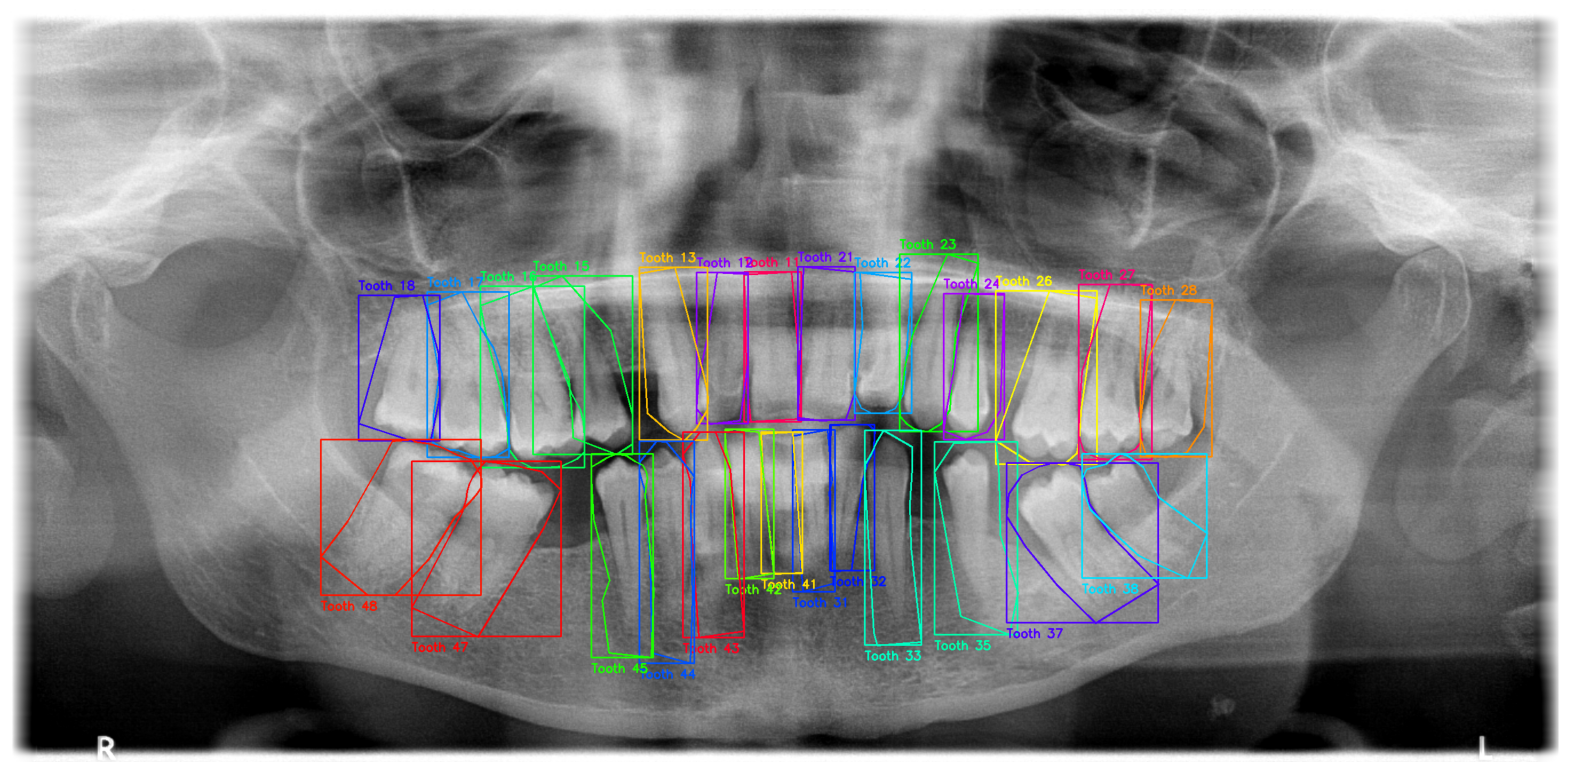

In [ ]:
# show an example xray with segmentation and bbox annotations

image_id = 1

annotated_image = visualize_annotations(json_path, image_folder, image_id)

plt.figure(figsize=(20, 10))  # Adjust size as needed
plt.imshow(annotated_image)
plt.axis('off')
plt.show()


In [ ]:
# split data

import json
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

# Load COCO-style annotations
with open(json_path, "r") as f:
    annotations = json.load(f)

# Extract image metadata
image_data = annotations["images"]
annotation_data = annotations["annotations"]

# Create a mapping of image_id -> file_name
image_id_to_file = {img["id"]: img["file_name"] for img in image_data}

# Create a mapping of image_id -> segmentation masks
image_id_to_masks = {}
for anno in annotation_data:
    image_id = anno["image_id"]
    segmentation = anno["segmentation"]
    if image_id not in image_id_to_masks:
        image_id_to_masks[image_id] = []
    image_id_to_masks[image_id].append(segmentation)

# Get all image IDs
image_ids = list(image_id_to_file.keys())

# Split into training and validation sets
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)


In [ ]:
# helper functions for training

def load_image(image_id, image_dir):
    """Load an image given its ID."""
    file_name = image_id_to_file[image_id]
    image_path = os.path.join(image_dir, file_name)
    image = Image.open(image_path).convert("RGB")
    return np.array(image)

from PIL import Image, ImageDraw

def generate_mask(image_id, image_size):
    """Generate a binary segmentation mask for the given image ID."""
    height, width = image_size  # Ensure correct dimension order
    mask = np.zeros((height, width), dtype=np.uint8)  # Height x Width

    if image_id not in image_id_to_masks:
        return mask  # No annotations for this image

    for segmentation in image_id_to_masks[image_id]:
        # Flatten points and create a polygon
        points = np.array(segmentation).reshape(-1, 2)

        # Create a blank image for the polygon
        polygon = Image.new("L", (width, height), 0)  # Width x Height order for PIL
        ImageDraw.Draw(polygon).polygon(points.flatten().tolist(), outline=1, fill=1)

        # Combine masks
        mask = np.maximum(mask, np.array(polygon))  # Ensure shapes match
    return mask


In [ ]:
#preprocess data
from PIL import Image, ImageDraw

def preprocess_data(image_ids, image_dir, image_size):
    """Preprocess images and masks for training/validation."""
    images = []
    masks = []
    for image_id in image_ids:
        image = load_image(image_id, image_dir)
        mask = generate_mask(image_id, image.shape[:2])

        # Resize to target size
        image = np.array(Image.fromarray(image).resize(image_size))
        mask = np.array(Image.fromarray(mask).resize(image_size, resample=Image.NEAREST))

        # Normalize image to [0, 1]
        image = image / 255.0

        # Expand mask to 1 channel
        mask = np.expand_dims(mask, axis=-1)

        images.append(image)
        masks.append(mask)
    return np.array(images), np.array(masks)

# Example usage
image_dir = image_folder  # Path to your images
image_size = (256, 256)  # Resize to 256x256
X_train, y_train = preprocess_data(train_ids, image_dir, image_size)
X_val, y_val = preprocess_data(val_ids, image_dir, image_size)


In [ ]:
import tensorflow as tf

def dice_score(y_true, y_pred):
    """
    Compute the Dice score using TensorFlow tensors with type casting.
    """
    y_true_f = tf.cast(tf.keras.backend.flatten(y_true), dtype=tf.float32)
    y_pred_f = tf.cast(tf.keras.backend.flatten(y_pred), dtype=tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-7)


In [ ]:
class DiceMetric(tf.keras.metrics.Metric):
    def __init__(self, name="dice_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.dice = self.add_weight(name="dice", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Compute the Dice score
        score = dice_score(y_true, y_pred)
        self.dice.assign(score)

    def result(self):
        return self.dice

    def reset_states(self):
        self.dice.assign(0.0)


In [ ]:
# Build a simple masking model with UNet
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_simple_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    b1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(b1)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(b1)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D((2, 2))(c3)
    c4 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    return Model(inputs, outputs)

# Example usage:
input_shape = (256, 256, 3)  # Rescale images to 256x256 if necessary
model = build_simple_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[DiceMetric()]
)


# import tensorflow as tf
# from tensorflow.keras import backend as K

# def focal_loss(gamma=2., alpha=0.25):
#     def focal_loss_fixed(y_true, y_pred):
#         epsilon = K.epsilon()
#         y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
#         pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#         pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#         return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - \
#                K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
#     return focal_loss_fixed

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     loss=focal_loss(),
#     metrics=[DiceMetric()]
# )

In [ ]:
pip install --upgrade tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompa

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    ModelCheckpoint("model_best.keras", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=60,
    callbacks=callbacks
)


Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - dice_score: 0.2178 - loss: 0.6570 - val_dice_score: 0.2008 - val_loss: 0.4710
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - dice_score: 0.2389 - loss: 0.4447 - val_dice_score: 0.2713 - val_loss: 0.3878
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - dice_score: 0.2919 - loss: 0.3858 - val_dice_score: 0.2859 - val_loss: 0.3700
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - dice_score: 0.3092 - loss: 0.3730 - val_dice_score: 0.3223 - val_loss: 0.3628
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - dice_score: 0.3270 - loss: 0.3586 - val_dice_score: 0.3662 - val_loss: 0.3357
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - dice_score: 0.3573 - loss: 0.3387 - val_dice_score: 0.3827 - val_loss: 0.3111
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - dice_score: 0.3892 - loss: 0.3223 - val_dice_score: 0.4009 - val_loss: 0.3130
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - dice_score: 0.4800 - l

In [ ]:
# Predict on the validation set
y_val_pred = model.predict(X_val)

# Threshold the predictions to get binary masks
y_val_pred_binary = (y_val_pred > 0.5).astype("float32")

# Compute the Dice score for the entire validation set
dice_scores = [dice_score(y_true, y_pred).numpy() for y_true, y_pred in zip(y_val, y_val_pred_binary)]
mean_dice_score = np.mean(dice_scores)

print(f"Mean Dice Score on Validation Set: {mean_dice_score:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
Mean Dice Score on Validation Set: 0.8606


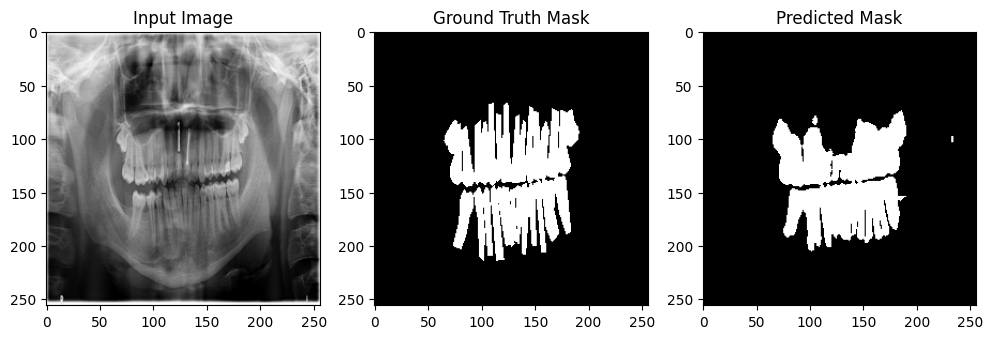

In [ ]:
import matplotlib.pyplot as plt

# Choose a sample index from the validation set
sample_index = 0  # Change this to view different samples

# Input image
image = X_val[sample_index]

# Ground truth mask
true_mask = y_val[sample_index].squeeze()

# Predicted mask
predicted_mask = y_val_pred_binary[sample_index].squeeze()

# Plot the results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(true_mask, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap="gray")

plt.show()


In [ ]:
model.save("simple_unet_model.keras")


# SEUnet

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.norm = nn.InstanceNorm2d(out_channels, affine=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = F.relu(x, inplace=True)
        return x


class FastSmoothSENorm(nn.Module):
    class SEWeights(nn.Module):
        def __init__(self, in_channels, reduction=2):
            super().__init__()
            self.conv1 = nn.Conv2d(
                in_channels,
                in_channels // reduction,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=True,
            )
            self.conv2 = nn.Conv2d(
                in_channels // reduction,
                in_channels,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=True,
            )

        def forward(self, x):
            b, c, h, w = x.size()
            out = torch.mean(x.view(b, c, -1), dim=-1).view(
                b, c, 1, 1
            )  # output_shape: in_channels x (1, 1, 1)
            out = F.relu(self.conv1(out))
            out = self.conv2(out)
            return out

    def __init__(self, in_channels, reduction=2):
        super(FastSmoothSENorm, self).__init__()
        self.norm = nn.InstanceNorm2d(in_channels, affine=False)
        self.gamma = self.SEWeights(in_channels, reduction)
        self.beta = self.SEWeights(in_channels, reduction)

    def forward(self, x):
        gamma = torch.sigmoid(self.gamma(x))
        beta = torch.tanh(self.beta(x))
        x = self.norm(x)
        return gamma * x + beta


class FastSmoothSeNormConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=2, **kwargs):
        super(FastSmoothSeNormConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=True, **kwargs)
        self.norm = FastSmoothSENorm(out_channels, reduction)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x, inplace=True)
        x = self.norm(x)
        return x


class RESseNormConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=2, **kwargs):
        super().__init__()
        self.conv1 = FastSmoothSeNormConv2d(
            in_channels, out_channels, reduction, **kwargs
        )

        if in_channels != out_channels:
            self.res_conv = FastSmoothSeNormConv2d(
                in_channels, out_channels, reduction, kernel_size=1, stride=1, padding=0
            )
        else:
            self.res_conv = None

    def forward(self, x):
        residual = self.res_conv(x) if self.res_conv else x
        x = self.conv1(x)
        x += residual
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=2, scale=2):
        super().__init__()
        self.scale = scale
        self.conv = FastSmoothSeNormConv2d(
            in_channels, out_channels, reduction, kernel_size=1, stride=1, padding=0
        )

    def forward(self, x):
        x = self.conv(x)
        x = F.interpolate(
            x, scale_factor=self.scale, mode="bilinear", align_corners=False
        )
        return x

import torch
from torch import nn
from torch.nn import functional as F


class UNet(nn.Module):
    def __init__(self, in_channels, n_cls, n_filters):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.n_cls = 1 if n_cls == 2 else n_cls
        self.n_filters = n_filters

        self.block_1_1_left = BasicConv2d(
            in_channels, n_filters, kernel_size=3, stride=1, padding=1
        )
        self.block_1_2_left = BasicConv2d(
            n_filters, n_filters, kernel_size=3, stride=1, padding=1
        )

        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64, 1/2
        self.block_2_1_left = BasicConv2d(
            n_filters, 2 * n_filters, kernel_size=3, stride=1, padding=1
        )
        self.block_2_2_left = BasicConv2d(
            2 * n_filters, 2 * n_filters, kernel_size=3, stride=1, padding=1
        )

        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128, 1/4
        self.block_3_1_left = BasicConv2d(
            2 * n_filters, 4 * n_filters, kernel_size=3, stride=1, padding=1
        )
        self.block_3_2_left = BasicConv2d(
            4 * n_filters, 4 * n_filters, kernel_size=3, stride=1, padding=1
        )

        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256, 1/8
        self.block_4_1_left = BasicConv2d(
            4 * n_filters, 8 * n_filters, kernel_size=3, stride=1, padding=1
        )
        self.block_4_2_left = BasicConv2d(
            8 * n_filters, 8 * n_filters, kernel_size=3, stride=1, padding=1
        )

        self.upconv_3 = nn.ConvTranspose2d(
            8 * n_filters,
            4 * n_filters,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.block_3_1_right = BasicConv2d(
            (4 + 4) * n_filters, 4 * n_filters, kernel_size=3, stride=1, padding=1
        )
        self.block_3_2_right = BasicConv2d(
            4 * n_filters, 4 * n_filters, kernel_size=3, stride=1, padding=1
        )

        self.upconv_2 = nn.ConvTranspose2d(
            4 * n_filters,
            2 * n_filters,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.block_2_1_right = BasicConv2d(
            (2 + 2) * n_filters, 2 * n_filters, kernel_size=3, stride=1, padding=1
        )
        self.block_2_2_right = BasicConv2d(
            2 * n_filters, 2 * n_filters, kernel_size=3, stride=1, padding=1
        )

        self.upconv_1 = nn.ConvTranspose2d(
            2 * n_filters,
            n_filters,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.block_1_1_right = BasicConv2d(
            (1 + 1) * n_filters, n_filters, kernel_size=3, stride=1, padding=1
        )
        self.block_1_2_right = BasicConv2d(
            n_filters, n_filters, kernel_size=3, stride=1, padding=1
        )

        self.conv1x1 = nn.Conv2d(
            n_filters, self.n_cls, kernel_size=1, stride=1, padding=0
        )

    def forward(self, x):

        ds0 = self.block_1_2_left(self.block_1_1_left(x))
        ds1 = self.block_2_2_left(self.block_2_1_left(self.pool_1(ds0)))
        ds2 = self.block_3_2_left(self.block_3_1_left(self.pool_2(ds1)))
        x = self.block_4_2_left(self.block_4_1_left(self.pool_3(ds2)))

        x = self.block_3_2_right(
            self.block_3_1_right(torch.cat([self.upconv_3(x), ds2], 1))
        )
        x = self.block_2_2_right(
            self.block_2_1_right(torch.cat([self.upconv_2(x), ds1], 1))
        )
        x = self.block_1_2_right(
            self.block_1_1_right(torch.cat([self.upconv_1(x), ds0], 1))
        )

        x = self.conv1x1(x)

        if self.n_cls == 1:
            return torch.sigmoid(x)
        else:
            return x


class SEUNet(nn.Module):
    """The model presented in the paper. This model is one of the multiple models that we tried in our experiments
    that it why it has such an awkward name."""

    def __init__(
        self, in_channels=1, n_cls=2, n_filters=64, reduction=2, return_logits=False
    ):
        super(SEUNet, self).__init__()
        self.in_channels = in_channels
        self.n_cls = 1 if n_cls == 2 else n_cls
        self.n_filters = n_filters
        self.return_logits = return_logits

        self.block_1_1_left = RESseNormConv2d(
            in_channels, n_filters, reduction, kernel_size=7, stride=1, padding=3
        )
        self.block_1_2_left = RESseNormConv2d(
            n_filters, n_filters, reduction, kernel_size=3, stride=1, padding=1
        )

        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block_2_1_left = RESseNormConv2d(
            n_filters, 2 * n_filters, reduction, kernel_size=3, stride=1, padding=1
        )
        self.block_2_2_left = RESseNormConv2d(
            2 * n_filters, 2 * n_filters, reduction, kernel_size=3, stride=1, padding=1
        )
        self.block_2_3_left = RESseNormConv2d(
            2 * n_filters, 2 * n_filters, reduction, kernel_size=3, stride=1, padding=1
        )

        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block_3_1_left = RESseNormConv2d(
            2 * n_filters, 4 * n_filters, reduction, kernel_size=3, stride=1, padding=1
        )
        self.block_3_2_left = RESseNormConv2d(
            4 * n_filters, 4 * n_filters, reduction, kernel_size=3, stride=1, padding=1
        )
        self.block_3_3_left = RESseNormConv2d(
            4 * n_filters, 4 * n_filters, reduction, kernel_size=3, stride=1, padding=1
        )

        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block_4_1_left = RESseNormConv2d(
            4 * n_filters, 8 * n_filters, reduction, kernel_size=3, stride=1, padding=1
        )
        self.block_4_2_left = RESseNormConv2d(
            8 * n_filters, 8 * n_filters, reduction, kernel_size=3, stride=1, padding=1
        )
        self.block_4_3_left = RESseNormConv2d(
            8 * n_filters, 8 * n_filters, reduction, kernel_size=3, stride=1, padding=1
        )

        self.pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block_5_1_left = RESseNormConv2d(
            8 * n_filters, 16 * n_filters, reduction, kernel_size=3, stride=1, padding=1
        )
        self.block_5_2_left = RESseNormConv2d(
            16 * n_filters,
            16 * n_filters,
            reduction,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.block_5_3_left = RESseNormConv2d(
            16 * n_filters,
            16 * n_filters,
            reduction,
            kernel_size=3,
            stride=1,
            padding=1,
        )

        self.upconv_4 = nn.ConvTranspose2d(
            16 * n_filters,
            8 * n_filters,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.block_4_1_right = FastSmoothSeNormConv2d(
            (8 + 8) * n_filters,
            8 * n_filters,
            reduction,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.block_4_2_right = FastSmoothSeNormConv2d(
            8 * n_filters, 8 * n_filters, reduction, kernel_size=3, stride=1, padding=1
        )
        self.vision_4 = UpConv(8 * n_filters, n_filters, reduction, scale=8)

        self.upconv_3 = nn.ConvTranspose2d(
            8 * n_filters,
            4 * n_filters,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.block_3_1_right = FastSmoothSeNormConv2d(
            (4 + 4) * n_filters,
            4 * n_filters,
            reduction,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.block_3_2_right = FastSmoothSeNormConv2d(
            4 * n_filters, 4 * n_filters, reduction, kernel_size=3, stride=1, padding=1
        )
        self.vision_3 = UpConv(4 * n_filters, n_filters, reduction, scale=4)

        self.upconv_2 = nn.ConvTranspose2d(
            4 * n_filters,
            2 * n_filters,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.block_2_1_right = FastSmoothSeNormConv2d(
            (2 + 2) * n_filters,
            2 * n_filters,
            reduction,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.block_2_2_right = FastSmoothSeNormConv2d(
            2 * n_filters, 2 * n_filters, reduction, kernel_size=3, stride=1, padding=1
        )
        self.vision_2 = UpConv(2 * n_filters, n_filters, reduction, scale=2)

        self.upconv_1 = nn.ConvTranspose2d(
            2 * n_filters,
            1 * n_filters,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.block_1_1_right = FastSmoothSeNormConv2d(
            (1 + 1) * n_filters,
            n_filters,
            reduction,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.block_1_2_right = FastSmoothSeNormConv2d(
            n_filters, n_filters, reduction, kernel_size=3, stride=1, padding=1
        )

        self.conv1x1 = nn.Conv2d(
            1 * n_filters, self.n_cls, kernel_size=1, stride=1, padding=0
        )

    def forward(self, x):

        ds0 = self.block_1_2_left(self.block_1_1_left(x))
        ds1 = self.block_2_3_left(
            self.block_2_2_left(self.block_2_1_left(self.pool_1(ds0)))
        )
        ds2 = self.block_3_3_left(
            self.block_3_2_left(self.block_3_1_left(self.pool_2(ds1)))
        )
        ds3 = self.block_4_3_left(
            self.block_4_2_left(self.block_4_1_left(self.pool_3(ds2)))
        )
        x = self.block_5_3_left(
            self.block_5_2_left(self.block_5_1_left(self.pool_4(ds3)))
        )

        x = self.block_4_2_right(
            self.block_4_1_right(torch.cat([self.upconv_4(x), ds3], 1))
        )
        sv4 = self.vision_4(x)

        x = self.block_3_2_right(
            self.block_3_1_right(torch.cat([self.upconv_3(x), ds2], 1))
        )
        sv3 = self.vision_3(x)

        x = self.block_2_2_right(
            self.block_2_1_right(torch.cat([self.upconv_2(x), ds1], 1))
        )
        sv2 = self.vision_2(x)

        x = self.block_1_1_right(torch.cat([self.upconv_1(x), ds0], 1))
        x = x + sv4 + sv3 + sv2
        x = self.block_1_2_right(x)

        x = self.conv1x1(x)

        if self.return_logits:
            return x
        else:
            if self.n_cls == 1:
                return torch.sigmoid(x)
            else:
                return x

In [ ]:
import torch
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images  # List of images (numpy arrays or tensors)
        self.masks = masks  # List of masks (numpy arrays or tensors)
        self.transform = transform  # Optional augmentations

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # Convert to torch tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0  # Normalize
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        return image, mask


In [ ]:
def dice_loss(y_pred, y_true):
    smooth = 1e-7
    y_pred = y_pred.contiguous().view(-1)
    y_true = y_true.contiguous().view(-1)
    intersection = (y_pred * y_true).sum()
    dice = (2.0 * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)
    return 1 - dice

def combined_loss(y_pred, y_true):
    bce = torch.nn.functional.binary_cross_entropy(y_pred, y_true)
    dice = dice_loss(y_pred, y_true)
    return bce + dice


In [ ]:
from torch.utils.data import DataLoader
from torch.optim import Adam

# Define hyperparameters
batch_size = 4
learning_rate = 1e-4
epochs = 20

# Initialize dataset and data loaders
train_dataset = SegmentationDataset(X_train, y_train)
val_dataset = SegmentationDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = SEUNet(in_channels=3, n_cls=1, n_filters=64).cuda()  # Use GPU if available

# Define optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()

        # Forward pass
        preds = model(images)

        # Compute loss
        loss = combined_loss(preds, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.cuda(), masks.cuda()
            preds = model(images)
            loss = combined_loss(preds, masks)
            val_loss += loss.item()

    # Print epoch results
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 36.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 27.06 MiB is free. Process 125759 has 14.72 GiB memory in use. Of the allocated memory 958.98 MiB is allocated by PyTorch, and 19.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def dice_score(y_pred, y_true):
    smooth = 1e-7
    y_pred = (y_pred > 0.5).float()  # Threshold at 0.5
    y_true = y_true.float()
    intersection = (y_pred * y_true).sum()
    dice = (2.0 * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)
    return dice.item()

# Evaluate on the validation set
model.eval()
val_dice = 0.0
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.cuda(), masks.cuda()
        preds = model(images)
        val_dice += dice_score(preds, masks)

val_dice /= len(val_loader)
print(f"Mean Dice Score on Validation Set: {val_dice:.4f}")


In [ ]:
torch.save(model.state_dict(), "seunet_segmentation_model.pth")


In [ ]:
import matplotlib.pyplot as plt

model.eval()
images, masks = next(iter(val_loader))
images, masks = images.cuda(), masks.cuda()
preds = model(images)

# Visualize the first sample
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(images[0].cpu().permute(1, 2, 0).numpy())

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(masks[0].cpu().squeeze(), cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(preds[0].cpu().detach().squeeze(), cmap="gray")
plt.show()


# SAM

In [ ]:
pip install git+https://github.com/facebookresearch/segment-anything.git



SyntaxError: invalid syntax (<ipython-input-69-8f2c51248093>, line 1)